In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import sqlalchemy
import os
import json


In [2]:
conn = psycopg2.connect(
    user="dcat", 
    password="dcat", 
    host="127.0.0.1", 
    port="54320", 
    database="dcat")

In [36]:
conn = psycopg2.connect(
    user="v-oidc-Pau-datacata-8M61CzhFYnWwyGe4RT5T-1573823273", 
    password="A1a-uUUBJHlTN9oyrAQB", 
    host="b27dbvl008.preprod.local", 
    port="5432", 
    database="datacatalog-term")

In [3]:
cur = conn.cursor()

In [4]:
print ( conn.get_dsn_parameters(),"\n")

{'user': 'dcat', 'dbname': 'dcat', 'host': '127.0.0.1', 'port': '54320', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



In [5]:
cur.execute("SELECT version();")
record = cur.fetchone()
print("You are connected to - ", record,"\n")

You are connected to -  ('PostgreSQL 12.0 (Debian 12.0-2.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',) 



In [24]:
conn.commit()

# Init

In [25]:
#Relationship description/attributes
cur.execute("delete from tbl_edge_desc")
#Relationships/Edges
cur.execute("delete from tbl_edge")
#Node details table
cur.execute("delete from tbl_node")

conn.commit()

# Get data

In [26]:
xls = pd.ExcelFile("../data/testdata.xlsx")
xls.sheet_names

['Formål GML',
 'Formål',
 'Ark1',
 'data-catalog-backend',
 'data-catalog-policies',
 'Category']

# Populate tables

### Relationships

In [27]:
relationships = ["has purpose", "based on purpose", "has attribute", "attribute of","belongs to category", "contains concept"]
index = 1
for relationship in relationships:
    insert_query = f"insert into tbl_edge_desc (prop) values ('{relationship}')"
    cur.execute(insert_query)
    index += 1
    
conn.commit()

In [28]:
df_links = sqlio.read_sql_query("select * from tbl_edge_desc", conn)
df_links

,id,prop
0,f8af72c4-c473-4fb7-8d83-46eeb5e20e15,has purpose
1,35eb6c1e-2ce6-46d4-895d-32a73b2d7a74,based on purpose
2,0debc683-2d8e-401b-91c2-8fb4883d5fb4,has attribute
3,18dd8f01-95b1-472b-ab20-70a9509b1809,attribute of
4,6dd750d5-d68a-4461-ab8a-0b3372d4b405,belongs to category
5,c78e346d-38fb-44ab-923c-34f01652efac,contains concept


### Processing activities

In [29]:
sheet=xls.sheet_names[1]
df_formål = pd.read_excel(xls, sheet, encoding='latin1')
df_formål = df_formål[['Forslag til endelig formålskode', 'Formålsbeskrivelse']]
df_formål.columns=['code', 'description']
df_formål['name'] = df_formål['code'].apply(lambda x: x.upper())
df_formål = df_formål.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True)
df_formål.drop(['code'], axis=1, inplace=True)
df_formål['type'] = 'prosessing activity'
df_formål.tail()

,description,name,type
33,Behandle og vurdere rett til uføretrygd som sk...,UFØRETRYGD,prosessing activity
34,Behandle og vurdere rett til ventelønn som ska...,VENTELØNN,prosessing activity
35,Behandle og vurdere rett til ytelser ved yrkes...,YRKESSKADE- OG SYKDOM,prosessing activity
36,Behandle og vurdere rett til ytelser til famil...,YTELSER TIL FAMILIEPLEIER,prosessing activity
37,Not Available -Verdi mangler,NOT AVAILABLE,prosessing activity


In [30]:
for index, row in df_formål.iterrows():
    id = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [31]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
33,bfe1a67c-c3b1-4c26-a376-5b2905737647,"{'name': 'UFØRETRYGD', 'type': 'prosessing act...",2019-11-20 13:13:52.567461
34,4bb07470-d6fa-4ff9-980e-f2a6adba42a2,"{'name': 'VENTELØNN', 'type': 'prosessing acti...",2019-11-20 13:13:52.567461
35,a488f080-55b0-4c30-aea7-cb6c40981b5a,"{'name': 'YRKESSKADE- OG SYKDOM', 'type': 'pro...",2019-11-20 13:13:52.567461
36,ff6352d9-40bf-4c13-ac7d-6b952b35dd5d,"{'name': 'YTELSER TIL FAMILIEPLEIER', 'type': ...",2019-11-20 13:13:52.567461
37,15657ef1-1b18-46c7-8b45-a8e41d28073c,"{'name': 'NOT AVAILABLE', 'type': 'prosessing ...",2019-11-20 13:13:52.567461


### Purpose

In [32]:
df_purpose = df_formål.copy()
df_purpose['type'] = 'purpose'

In [33]:
for i, row in df_purpose.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [34]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
71,3ec05362-3a13-44d6-b8c2-bbc1fb5bbec6,"{'name': 'KRIGSPENSJON', 'type': 'purpose', 'd...",2019-11-20 13:13:57.114635
72,2135f639-a728-4b72-83b8-7bd0d96dec9e,"{'name': 'LØNNSGARANTI', 'type': 'purpose', 'd...",2019-11-20 13:13:57.114635
73,cd24a3a9-b524-4904-b047-b15f30887af9,"{'name': 'MEDLEMSKAP OG AVGIFT', 'type': 'purp...",2019-11-20 13:13:57.114635
74,280610fa-254f-4b5d-a608-9417f5ea2ec2,"{'name': 'MENERSTATNING', 'type': 'purpose', '...",2019-11-20 13:13:57.114635
75,4a504954-54f2-4cc3-89ff-a5a15bafacc8,"{'name': 'OMSORGSOPPTJENING', 'type': 'purpose...",2019-11-20 13:13:57.114635


### Legal basis

In [35]:
sheet=xls.sheet_names[4]
df_legal_basis = pd.read_excel(xls, sheet, encoding='latin1')
df_legal_basis = df_legal_basis[['legalBasisDescription']].drop_duplicates()
df_legal_basis.columns=['name']
df_legal_basis = df_legal_basis.append({'name': 'NOT AVAILABLE'}, ignore_index=True)
df_legal_basis['type'] = 'legal_basis'
df_legal_basis.head()

,name,type
0,Ftrl. § 11-20,legal_basis
1,"Ftrl. §§ 3-16, 3-24, 3-25, 20-8.",legal_basis
2,"Kapittel 3, 19, 20 0g 22",legal_basis
3,Ftrl § 3-2 og § 3-3,legal_basis
4,Barnetrygdloven § 9,legal_basis


In [36]:
for i, row in df_legal_basis.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [37]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
232,28cade6a-1577-436d-9c7f-fa54f80bfe70,"{'name': '§ 22-1 og taushetsplikt', 'type': 'l...",2019-11-20 13:14:06.396981
233,b0ff8394-6a60-49eb-a855-823e401abe2c,"{'name': 'Kap 8. § 22-1, 22-13 og 22-15, taush...",2019-11-20 13:14:06.396981
234,4b42a263-3bca-4561-b409-a47a31c90470,"{'name': 'Fvl § 12 ', 'type': 'legal_basis'}",2019-11-20 13:14:06.396981
235,c6c53a02-ae2b-46d6-acaf-3520dcaea74b,{'name': 'Det legges til grunn at Lgl + Lgf ka...,2019-11-20 13:14:06.396981
236,390dcddb-34b1-485d-a1db-2d48bf801411,"{'name': 'NOT AVAILABLE', 'type': 'legal_basis'}",2019-11-20 13:14:06.396981


### Concepts

In [38]:
sheet=xls.sheet_names[3]

df_concepts = pd.read_excel(xls, sheet, encoding='latin1')
df_concepts = df_concepts[['title', 'description']]
df_concepts.columns=['name', 'description']
df_concepts['name'] = df_concepts['name'].apply(lambda x: x.strip().upper())
df_concepts = df_concepts.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True).drop_duplicates()
df_concepts['type'] = 'concept'
df_concepts.head()

,name,description,type
0,SIVILSTAND,En overordnet kategori som beskriver en person...,concept
1,ARBEIDSFORHOLD,"Avtaleforhold hvor den ene part, arbeidstakere...",concept
2,KJØNN,TODO - mangler i begrepskatalogen og i MFNs be...,concept
3,NAVN,I Norge skal alle ha fornavn og ett enkelt ell...,concept
4,FØDSELSDATO,Datoen personen er født.,concept


In [45]:
for i, row in df_concepts.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [46]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
253,28cade6a-1577-436d-9c7f-fa54f80bfe70,"{'name': '§ 22-1 og taushetsplikt', 'type': 'l...",2019-11-20 13:14:06.396981
254,b0ff8394-6a60-49eb-a855-823e401abe2c,"{'name': 'Kap 8. § 22-1, 22-13 og 22-15, taush...",2019-11-20 13:14:06.396981
255,4b42a263-3bca-4561-b409-a47a31c90470,"{'name': 'Fvl § 12 ', 'type': 'legal_basis'}",2019-11-20 13:14:06.396981
256,c6c53a02-ae2b-46d6-acaf-3520dcaea74b,{'name': 'Det legges til grunn at Lgl + Lgf ka...,2019-11-20 13:14:06.396981
257,390dcddb-34b1-485d-a1db-2d48bf801411,"{'name': 'NOT AVAILABLE', 'type': 'legal_basis'}",2019-11-20 13:14:06.396981


### Categories

In [48]:
sheet=xls.sheet_names[3]
df_categories = pd.read_excel(xls, sheet, encoding='latin1')
df_categories = df_categories[['categories']]
df_categories.columns=['name']
df_categories['name'] = df_categories['name'].apply(lambda x: x.strip().upper())
df_categories = df_categories.append({'name': 'NOT AVAILABLE'}, ignore_index=True).drop_duplicates()
df_categories['type'] = 'category'
df_categories.head()

,name,type
0,PERSONALIA,category
1,ARBEIDSFORHOLD,category
6,KONTAKTOPPLYSNINGER,category
9,FAMILIERELASJONER,category
16,FOLKETRYGD,category


In [49]:
for i, row in df_categories.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

### Nodes

In [50]:
df_nodes = sqlio.read_sql_query("select * from tbl_node", conn)
df_nodes['name'] = df_nodes['prop'].apply(lambda x : x['name'])
df_nodes['type'] = df_nodes['prop'].apply(lambda x : x['type'])
df_nodes.head()

,id,prop,created,name,type
0,e27ef8ad-10cd-43df-b8e5-72107dde5329,"{'name': 'SIVILSTAND', 'type': 'concept', 'des...",2019-11-20 13:16:35.013411,SIVILSTAND,concept
1,ec1c37f0-508d-4aeb-a333-f1c6390da1c0,"{'name': 'ARBEIDSFORHOLD', 'type': 'concept', ...",2019-11-20 13:16:35.013411,ARBEIDSFORHOLD,concept
2,45c8a383-1123-4fe9-994c-de38e3de7ce5,"{'name': 'KJØNN', 'type': 'concept', 'descript...",2019-11-20 13:16:35.013411,KJØNN,concept
3,d9a3766e-bd44-4c08-bc11-9ed6c5540027,"{'name': 'NAVN', 'type': 'concept', 'descripti...",2019-11-20 13:16:35.013411,NAVN,concept
4,0ebebc95-f3ca-4a49-b024-48f958d9022a,"{'name': 'FØDSELSDATO', 'type': 'concept', 'de...",2019-11-20 13:16:35.013411,FØDSELSDATO,concept


### Edges

In [51]:
sheet=xls.sheet_names[3]
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['title', 'categories']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,SIVILSTAND,PERSONALIA
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,KJØNN,PERSONALIA
3,NAVN,PERSONALIA
4,FØDSELSDATO,PERSONALIA


In [52]:
df_links = sqlio.read_sql_query("select * from tbl_edge_desc", conn)
df_links

,id,prop
0,f8af72c4-c473-4fb7-8d83-46eeb5e20e15,has purpose
1,35eb6c1e-2ce6-46d4-895d-32a73b2d7a74,based on purpose
2,0debc683-2d8e-401b-91c2-8fb4883d5fb4,has attribute
3,18dd8f01-95b1-472b-ab20-70a9509b1809,attribute of
4,6dd750d5-d68a-4461-ab8a-0b3372d4b405,belongs to category
5,c78e346d-38fb-44ab-923c-34f01652efac,contains concept


In [79]:
cur.execute("select id::uuid from tbl_edge_desc where prop like 'contains concept'")
desc = cur.fetchone()
desc[0]


'c78e346d-38fb-44ab-923c-34f01652efac'

In [91]:
conn.commit()

In [92]:
cur.execute("delete from tbl_edge")
conn.commit()

for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'category')), 'id'].item()
    statement = f"insert into tbl_edge values (cast('{source_id}' as uuid),cast('{target_id}' as uuid),array[cast('{desc[0]}' as uuid)],now());"
    print(statement)
    cur.execute(statement)
    
conn.commit()

insert into tbl_edge values (cast('e27ef8ad-10cd-43df-b8e5-72107dde5329' as uuid),cast('83fb6213-5f1a-467f-8631-1b3aabe0ca13' as uuid),array[cast('c78e346d-38fb-44ab-923c-34f01652efac' as uuid)],now());
insert into tbl_edge values (cast('ec1c37f0-508d-4aeb-a333-f1c6390da1c0' as uuid),cast('1dc07a6a-2014-4d76-a769-bd7dd2113864' as uuid),array[cast('c78e346d-38fb-44ab-923c-34f01652efac' as uuid)],now());
insert into tbl_edge values (cast('45c8a383-1123-4fe9-994c-de38e3de7ce5' as uuid),cast('83fb6213-5f1a-467f-8631-1b3aabe0ca13' as uuid),array[cast('c78e346d-38fb-44ab-923c-34f01652efac' as uuid)],now());
insert into tbl_edge values (cast('d9a3766e-bd44-4c08-bc11-9ed6c5540027' as uuid),cast('83fb6213-5f1a-467f-8631-1b3aabe0ca13' as uuid),array[cast('c78e346d-38fb-44ab-923c-34f01652efac' as uuid)],now());
insert into tbl_edge values (cast('0ebebc95-f3ca-4a49-b024-48f958d9022a' as uuid),cast('83fb6213-5f1a-467f-8631-1b3aabe0ca13' as uuid),array[cast('c78e346d-38fb-44ab-923c-34f01652efac' as 

In [93]:
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['categories', 'title']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,PERSONALIA,SIVILSTAND
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,PERSONALIA,KJØNN
3,PERSONALIA,NAVN
4,PERSONALIA,FØDSELSDATO


In [176]:
for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'concept')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'category')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'concept')), 'id'].item()
    cur.execute(f"insert into tbl_edge values ({source_id},{target_id},array[6],now());")
    
conn.commit()


In [94]:
sql = "select * from tbl_edge"
df = sqlio.read_sql_query(sql, conn)
df.head()

,n1,n2,prop,created
0,e27ef8ad-10cd-43df-b8e5-72107dde5329,83fb6213-5f1a-467f-8631-1b3aabe0ca13,{c78e346d-38fb-44ab-923c-34f01652efac},2019-11-20 13:41:06.163501
1,ec1c37f0-508d-4aeb-a333-f1c6390da1c0,1dc07a6a-2014-4d76-a769-bd7dd2113864,{c78e346d-38fb-44ab-923c-34f01652efac},2019-11-20 13:41:06.163501
2,45c8a383-1123-4fe9-994c-de38e3de7ce5,83fb6213-5f1a-467f-8631-1b3aabe0ca13,{c78e346d-38fb-44ab-923c-34f01652efac},2019-11-20 13:41:06.163501
3,d9a3766e-bd44-4c08-bc11-9ed6c5540027,83fb6213-5f1a-467f-8631-1b3aabe0ca13,{c78e346d-38fb-44ab-923c-34f01652efac},2019-11-20 13:41:06.163501
4,0ebebc95-f3ca-4a49-b024-48f958d9022a,83fb6213-5f1a-467f-8631-1b3aabe0ca13,{c78e346d-38fb-44ab-923c-34f01652efac},2019-11-20 13:41:06.163501


In [95]:
sql = """
create or replace function graph_search1(      
  IN i_root uuid,                       -- The node that the search is based on        
  IN i_depth int  default 99999,       -- the tier to search (the depth limit)      
  IN i_limit int8 default 2000000000,  -- limit the number of records returned for each tier      
  OUT o_path uuid[],                    -- output: path, an array of IDs      
  OUT o_point1 uuid,                    -- output: point 1 ID      
  OUT o_point2 uuid,                    -- output: point 2 ID      
  OUT o_link_prop uuid[],              -- output: the connection property between the two current points      
  OUT o_link_prop_all text,            -- output: the connection property from the starting node to the current node      
  OUT o_depth int                      -- output: current depth (tier)      
) returns setof record as 
$$
      
declare      
  sql text;      
begin      
sql := format($_$      
WITH RECURSIVE search_graph(        
  n1,     -- point 1        
  n2,     -- point 2        
  prop,   -- current edge property      
  all_prop,  -- properties of all edges  
  depth,  -- current depth, starting from 1         
  path    -- path, stored as an array         
) AS (        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- ROOT node query        
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property        
      g.prop::text as all_prop,          -- properties of all edges  
          1 depth,                           -- initial depth=1        
          ARRAY[g.n1, g.n2] path             -- initial path        
        FROM tbl_edge AS g         
        WHERE         
          n1 = %s                            -- ROOT node=?        
          limit %s                           -- How many records are limited at each tier?        
        ) t        
      UNION ALL        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- recursive clause         
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property     
      sg.all_prop || g.prop::text as all_prop,    -- properties of all edges  
          sg.depth + 1 depth,                   -- depth +1        
          sg.path || g.n2 path                 -- Add a new point to the path        
        FROM tbl_edge AS g, search_graph AS sg    -- circular INNER JOIN        
        WHERE         
          g.n1 = sg.n2                       -- recursive JOIN condition        
          AND (g.n2 <> ALL(sg.path))                      -- Prevent loop, determine whether it is a loop and judge if the new point is already in the previous path   
          AND sg.depth <= %s                 -- search depth =?          
          limit %s                           -- How many records are limited at each tier?       
        ) t        
)        
SELECT path as o_path, n1 as o_point1, n2 as o_point2, prop as o_link_prop, all_prop as o_link_prop_all, depth as o_depth      
FROM search_graph;                           -- query a recursive table. You can add LIMIT output or use a cursor       
$_$, i_root, i_limit, i_depth, i_limit      
);      
      
return query execute sql;      
      
end;      

$$
 language plpgsql strict;   
"""

cur.execute(sql)

In [96]:
conn.commit()

In [99]:
%%time
sql = "select * from graph_search1(CAST('45c8a383-1123-4fe9-994c-de38e3de7ce5' AS UUID))"
df = sqlio.read_sql_query(sql, conn)

DatabaseError: Execution failed on sql 'select * from graph_search1(CAST('45c8a383-1123-4fe9-994c-de38e3de7ce5' AS UUID))': syntax error at or near "c8a383"
LINE 20:           n1 = 45c8a383-1123-4fe9-994c-de38e3de7ce5         ...
                          ^
QUERY:        
WITH RECURSIVE search_graph(        
  n1,     -- point 1        
  n2,     -- point 2        
  prop,   -- current edge property      
  all_prop,  -- properties of all edges  
  depth,  -- current depth, starting from 1         
  path    -- path, stored as an array         
) AS (        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- ROOT node query        
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property        
      g.prop::text as all_prop,          -- properties of all edges  
          1 depth,                           -- initial depth=1        
          ARRAY[g.n1, g.n2] path             -- initial path        
        FROM tbl_edge AS g         
        WHERE         
          n1 = 45c8a383-1123-4fe9-994c-de38e3de7ce5                            -- ROOT node=?        
          limit 2000000000                           -- How many records are limited at each tier?        
        ) t        
      UNION ALL        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- recursive clause         
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property     
      sg.all_prop || g.prop::text as all_prop,    -- properties of all edges  
          sg.depth + 1 depth,                   -- depth +1        
          sg.path || g.n2 path                 -- Add a new point to the path        
        FROM tbl_edge AS g, search_graph AS sg    -- circular INNER JOIN        
        WHERE         
          g.n1 = sg.n2                       -- recursive JOIN condition        
          AND (g.n2 <> ALL(sg.path))                      -- Prevent loop, determine whether it is a loop and judge if the new point is already in the previous path   
          AND sg.depth <= 99999                 -- search depth =?          
          limit 2000000000                           -- How many records are limited at each tier?       
        ) t        
)        
SELECT path as o_path, n1 as o_point1, n2 as o_point2, prop as o_link_prop, all_prop as o_link_prop_all, depth as o_depth      
FROM search_graph;                           -- query a recursive table. You can add LIMIT output or use a cursor       

CONTEXT:  PL/pgSQL function graph_search1(uuid,integer,bigint) line 50 at RETURN QUERY


In [181]:
sql = "select * from graph_search1(262)"
df = sqlio.read_sql_query(sql, conn)

In [182]:
df

,o_path,o_point1,o_point2,o_link_prop,o_link_prop_all,o_depth
0,"[262, 247]",262,247,[6],{6},1
1,"[262, 248]",262,248,[6],{6},1
2,"[262, 249]",262,249,[6],{6},1
3,"[262, 250]",262,250,[6],{6},1
4,"[262, 252]",262,252,[6],{6},1
5,"[262, 253]",262,253,[6],{6},1
6,"[262, 255]",262,255,[6],{6},1
7,"[262, 256]",262,256,[6],{6},1


In [183]:
df_edgelist=df[['o_point1','o_point2','o_link_prop','o_depth']].copy()
df_edgelist.columns=['source','target','id','weight']
df_edgelist['id'] = df_edgelist['id'].apply(lambda x: x[0])
df_edgelist = pd.merge(df_edgelist, df_links, on='id', how='left')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='source', right_on='id')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='target', right_on='id')
df_edgelist = df_edgelist[['prop', 'name_x', 'name_y','id','id_y', 'weight']]
df_edgelist.columns = ['name', 'source', 'target','target_node_id','source_node_id', 'weight']
df_edgelist

,name,source,target,target_node_id,source_node_id,weight
0,contains concept,FAMILIERELASJONER,ADOPSJON,247,262,1
1,contains concept,FAMILIERELASJONER,BARN,248,262,1
2,contains concept,FAMILIERELASJONER,DAGLIG OMSORG,249,262,1
3,contains concept,FAMILIERELASJONER,DELT BOSTED,250,262,1
4,contains concept,FAMILIERELASJONER,FARSKAP,252,262,1
5,contains concept,FAMILIERELASJONER,FLERFØDSEL,253,262,1
6,contains concept,FAMILIERELASJONER,FORELDREANSVAR,255,262,1
7,contains concept,FAMILIERELASJONER,FORSTERFORELDRE,256,262,1


In [184]:
#!pip install nx_altair

In [185]:
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')
import networkx as nx
import nx_altair as nxa
import numpy as np

G = nx.from_pandas_edgelist(df_edgelist, 'source', 'target', ['name','target_node_id','source_node_id','weight'])
pos = nx.spring_layout(G)

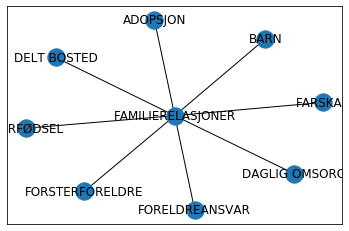

In [186]:
nx.draw_networkx(
    G=G,
    pos=pos
)

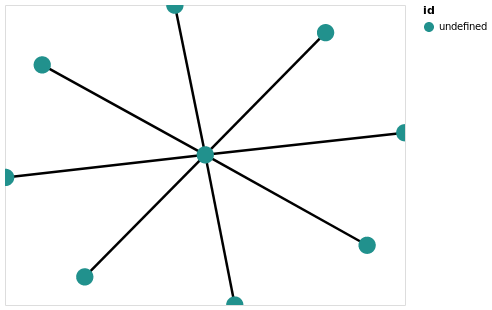

In [187]:
# Compute positions for viz.
pos = nx.spring_layout(G)

viz = nxa.draw_networkx(
    G, pos=pos,
    node_color='id:N',
    cmap='viridis',
    width='weight:N',
    edge_color='black',
    node_tooltip=['weight:N']
)

viz.interactive()